In [78]:
import pandas as pd
import io, os, sys, types, time, datetime, math, random, requests, subprocess, tempfile
from io import StringIO
import random
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

In [79]:
headers = ['Class', 'CapShape','CapSurface', 'CapColor','Bruises', 'Odor','GillAttachment',
           'GillSpacing','GillSize','GillColor','StalkShape', 'StalkRoot','StalkAboveRing', 
           'StalkBelowRing','ColorAboveRing', 'ColorBelowRing','VeilType', 'VeilColor',
           'RingNumber', 'RingType','SporeColor','Population','Habitat']

mushroom_dataset_raw = pd.read_csv("dataset/agaricus-lepiota.data",header = None,names = headers,
                      sep = ',',na_values=["?"],engine='python')

mushroom_dataset_raw.head()

,Class,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [80]:
mushroom_dataset_raw.describe()

,Class,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [81]:
mushroom_dataset_raw.shape

(8124, 23)

<Axes: >

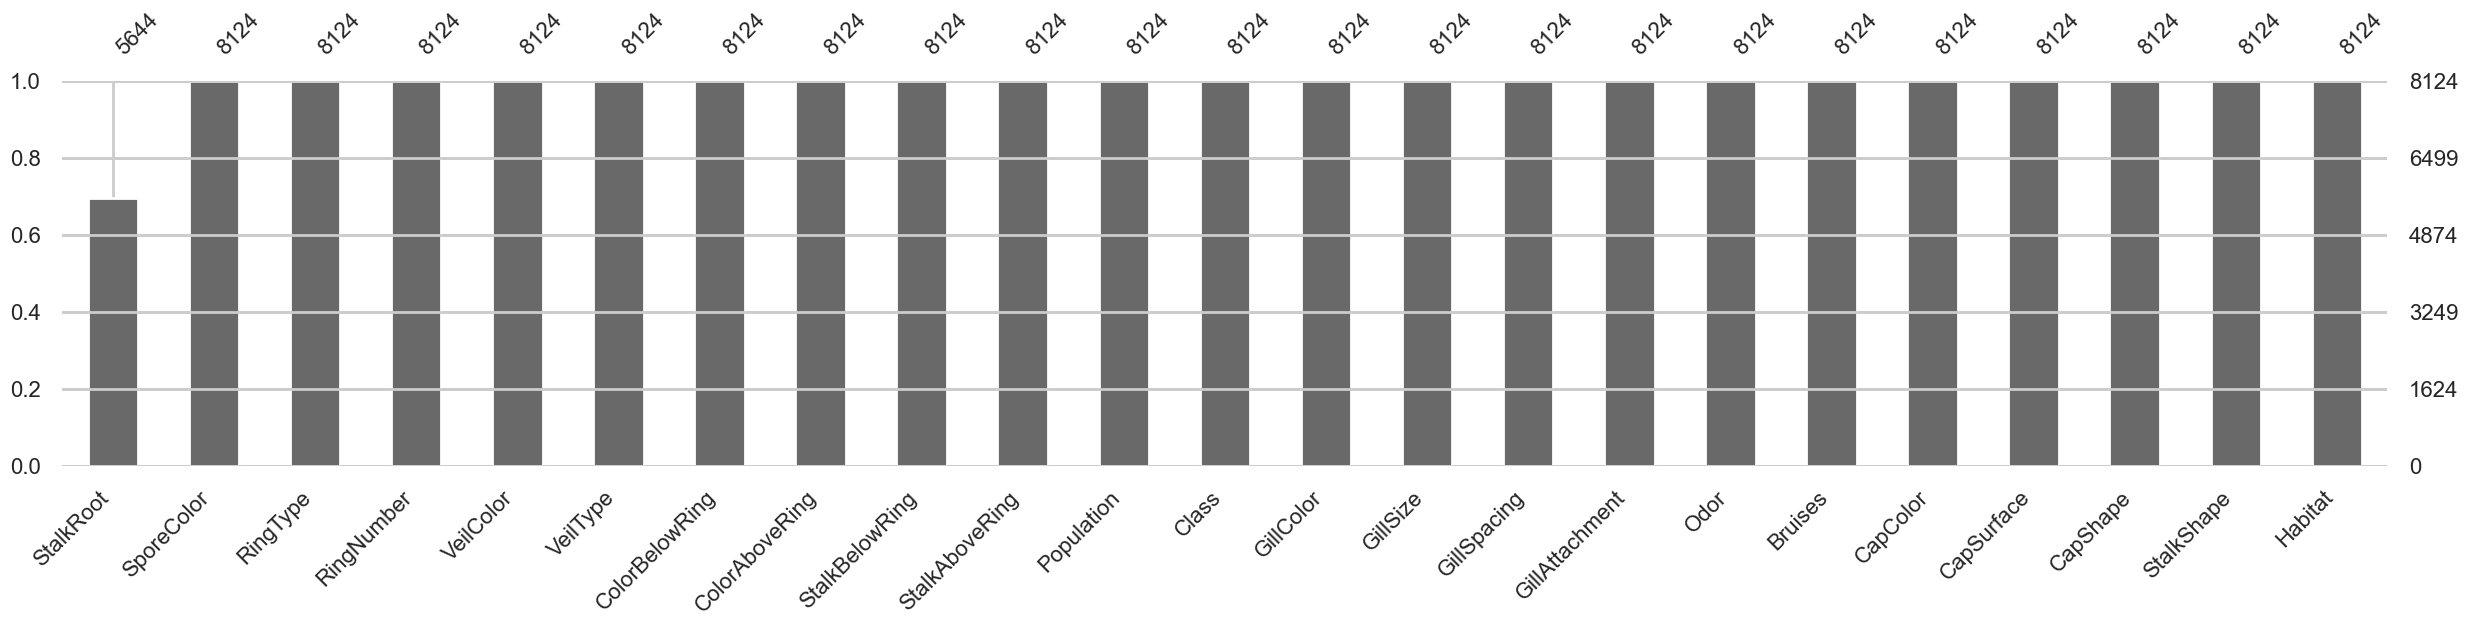

In [82]:
missingno.bar(mushroom_dataset_raw, sort='ascending', figsize = (30,5))

### Feature Cleaning and Imputation 
Identifying and handling inconsistencies, errors, or missing values in the dataset's features aims to ensure that the data is of high quality and suitable for analysis or modeling.

In [83]:
mushroom_dataset_bin = pd.DataFrame()

In [84]:
mushroom_dataset_raw.loc[mushroom_dataset_raw['Class'] == 'e', 'Class'] = 1
mushroom_dataset_raw.loc[mushroom_dataset_raw['Class'] == 'p', 'Class'] = 0
mushroom_dataset_bin['Class'] = mushroom_dataset_raw['Class']

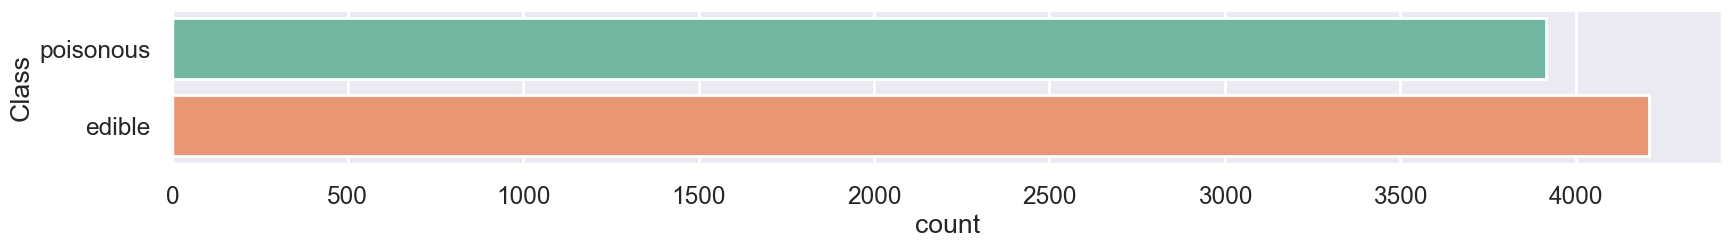

In [85]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(20, 2)) 
g = sns.countplot(y="Class", data=mushroom_dataset_bin, palette="Set2")
g.set_yticklabels(['poisonous', 'edible'])
plt.show()

In [86]:
mushroom_dataset_bin['CapShape'] = mushroom_dataset_raw['CapShape']
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 'b', 'CapShape'] = 'bell'
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 'c', 'CapShape'] = 'conical'
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 'x', 'CapShape'] = 'convex'
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 'f', 'CapShape'] = 'flat'
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 'k', 'CapShape'] = 'knobbed'
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 's', 'CapShape'] = 'sunken'

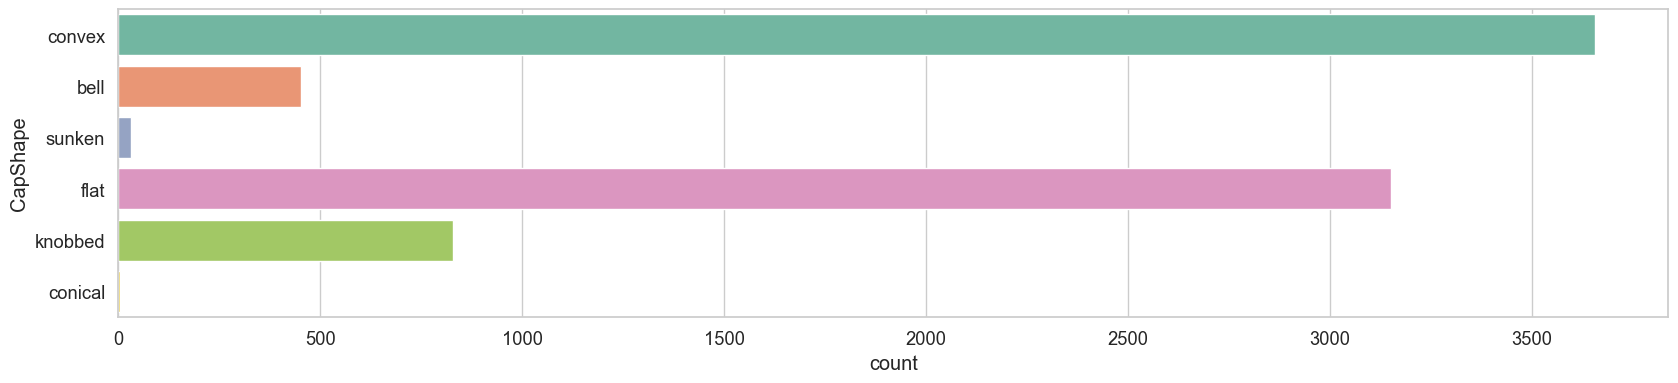

In [87]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2})
g = sns.countplot(y="CapShape", data=mushroom_dataset_raw, palette="Set2");

In [88]:
mushroom_dataset_bin['Population'] = mushroom_dataset_raw['Population']
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 'a', 'Population'] = 'abundant'
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 'c', 'Population'] = 'clustered'
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 'n', 'Population'] = 'numerous'
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 's', 'Population'] = 'scattered'
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 'v', 'Population'] = 'several'
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 'y', 'Population'] = 'solitary'

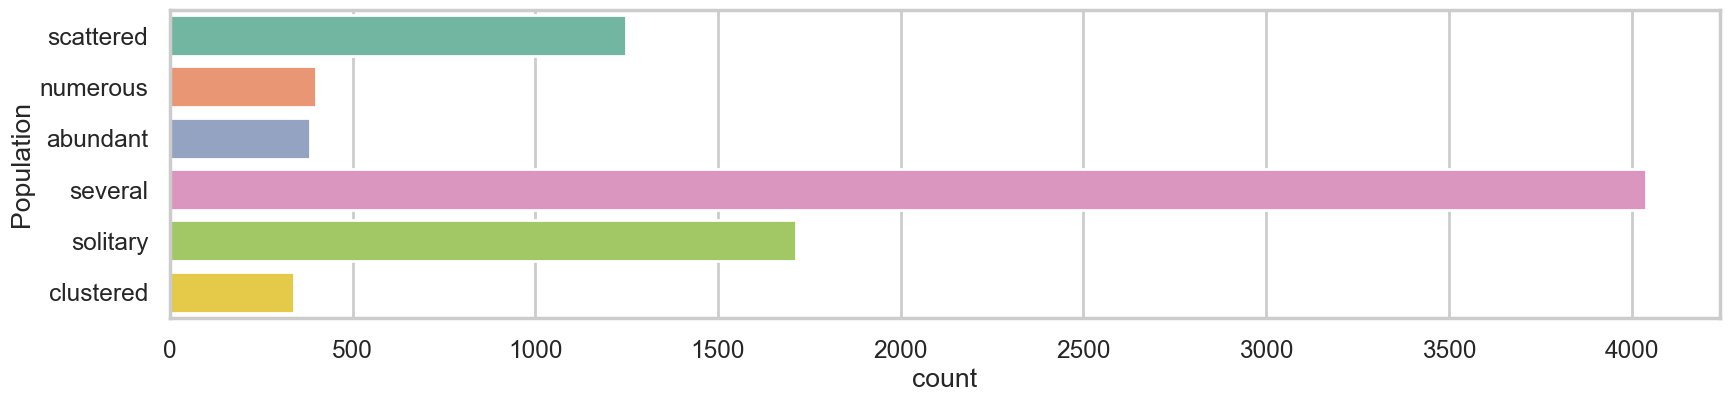

In [89]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 2})
g = sns.countplot(y="Population", data=mushroom_dataset_raw, palette="Set2");

### Feature Encoding
Converting Categorical Features into values, performing both One-Hot and Label encoding.

In [90]:
# One Hot Encodes all labels before Machine Learning
one_hot_cols = mushroom_dataset_bin.columns.tolist()
one_hot_cols.remove('Class')
dataset_bin_enc = pd.get_dummies(mushroom_dataset_bin, columns=one_hot_cols)
dataset_bin_enc.head()

,Class,CapShape_b,CapShape_c,CapShape_f,CapShape_k,CapShape_s,CapShape_x,Population_a,Population_c,Population_n,Population_s,Population_v,Population_y
0,0,False,False,False,False,False,True,False,False,False,True,False,False
1,1,False,False,False,False,False,True,False,False,True,False,False,False
2,1,True,False,False,False,False,False,False,False,True,False,False,False
3,0,False,False,False,False,False,True,False,False,False,True,False,False
4,1,False,False,False,False,False,True,True,False,False,False,False,False


In [91]:
dataset_con_enc = pd.DataFrame({col: mushroom_dataset_raw[col].astype('category').cat.codes for col in mushroom_dataset_raw}, index=mushroom_dataset_raw.index)
dataset_con_enc.head()

,Class,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
0,0,2,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,1,2,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,1,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,0,2,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,1,2,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


### Correlation

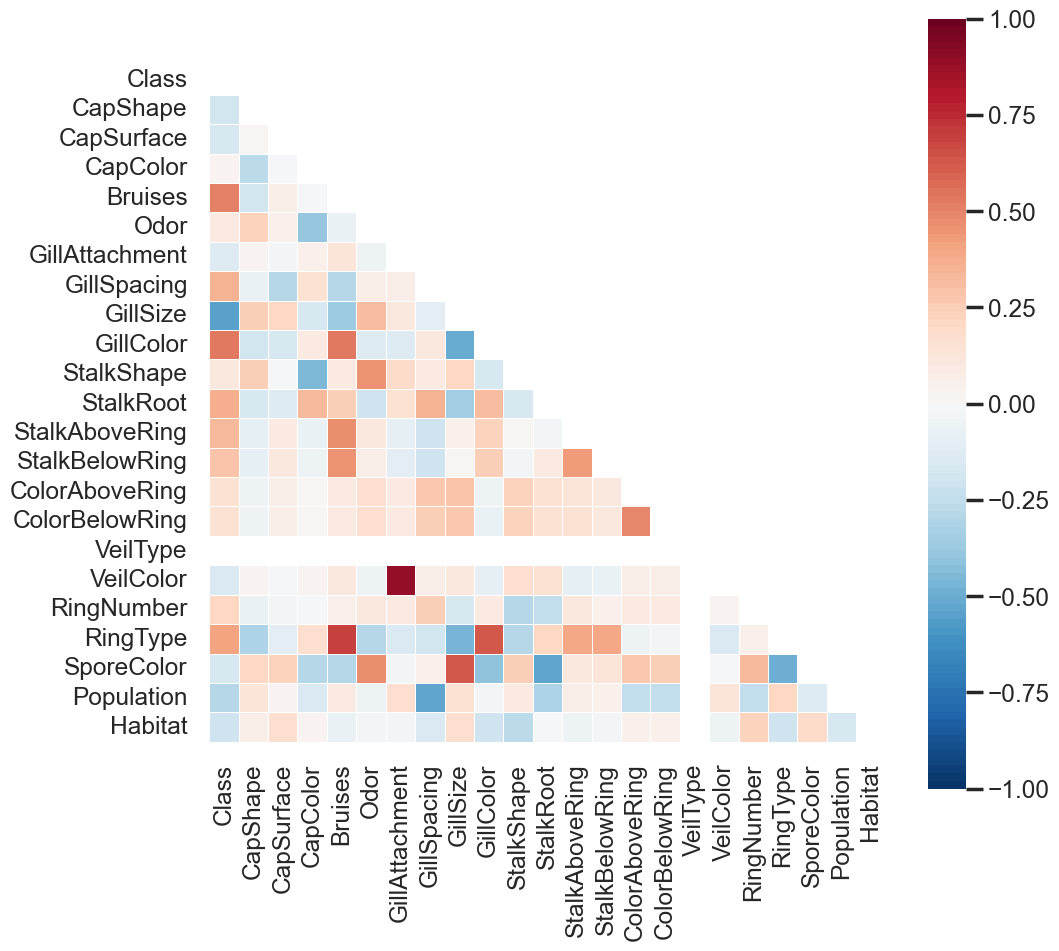

In [92]:
sns.set_style('white')
fig = plt.figure(figsize=(24,10))

plt.subplot(1, 2, 2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

### Feature Importance


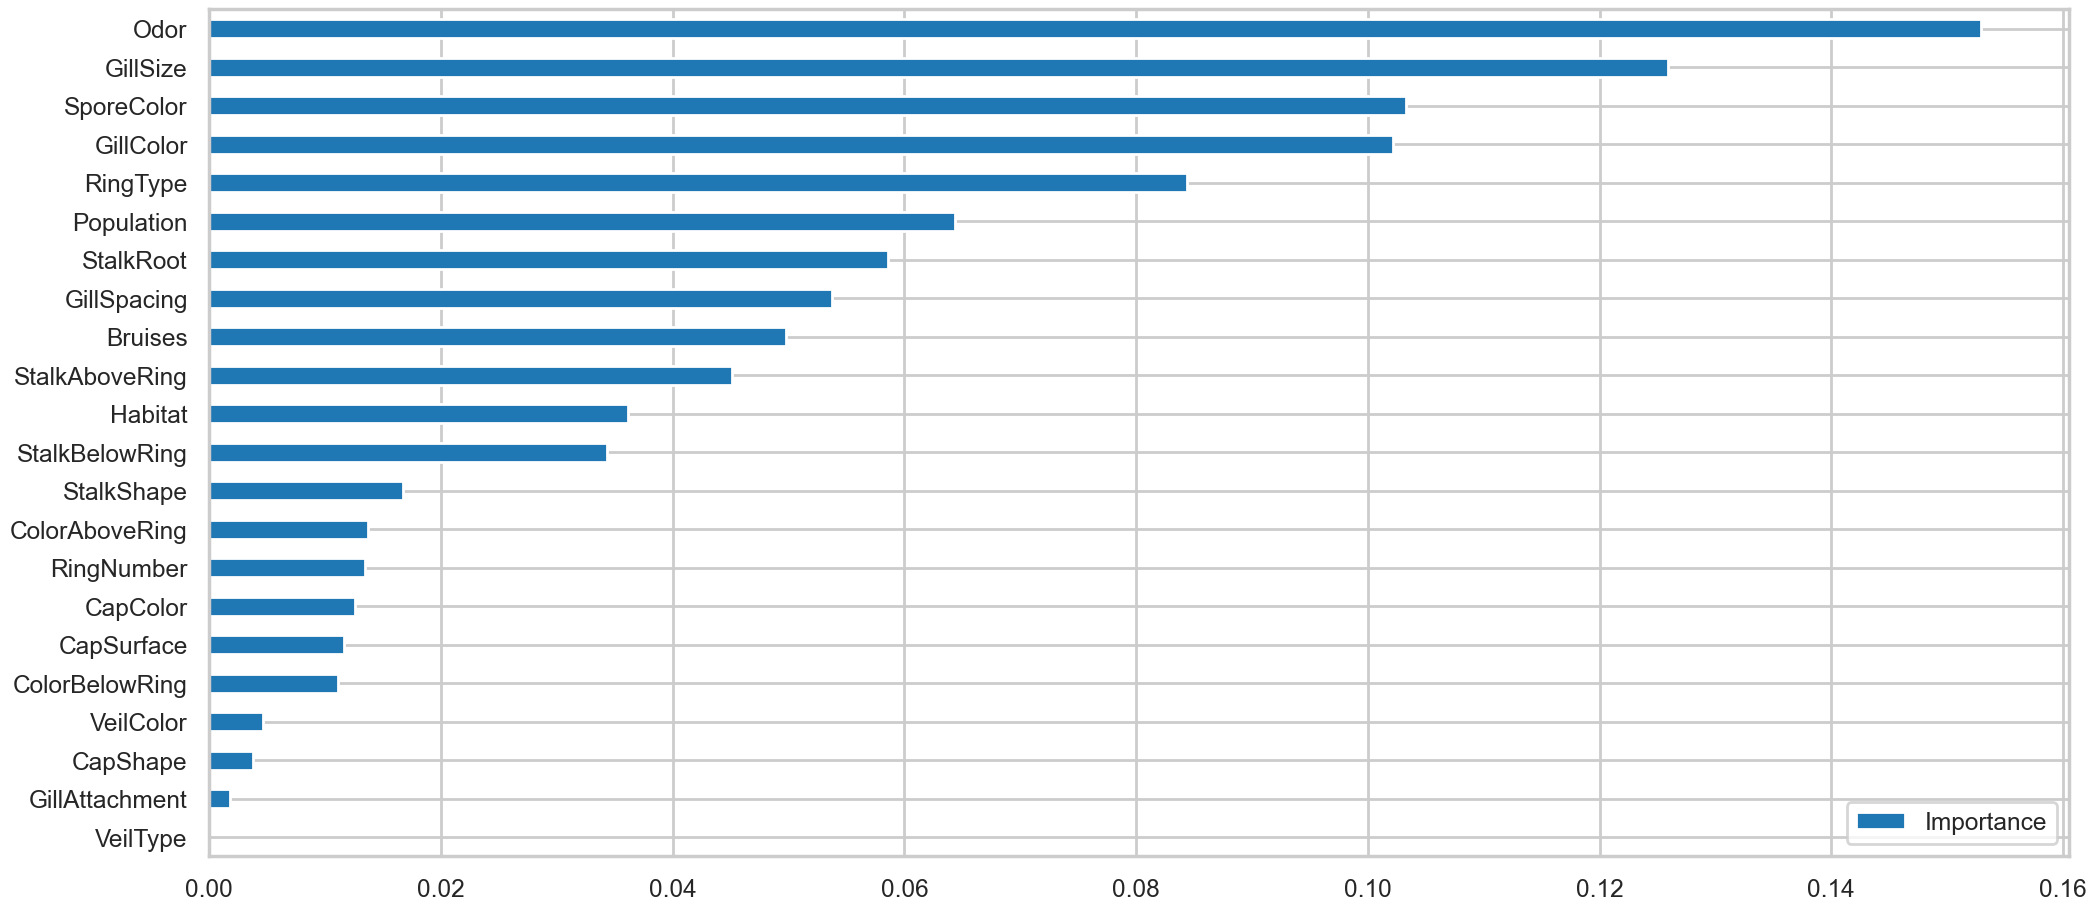

In [137]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('Class', axis=1), dataset_con_enc['Class'])

sns.set_style('whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('Class', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(24,len(importance)/2));

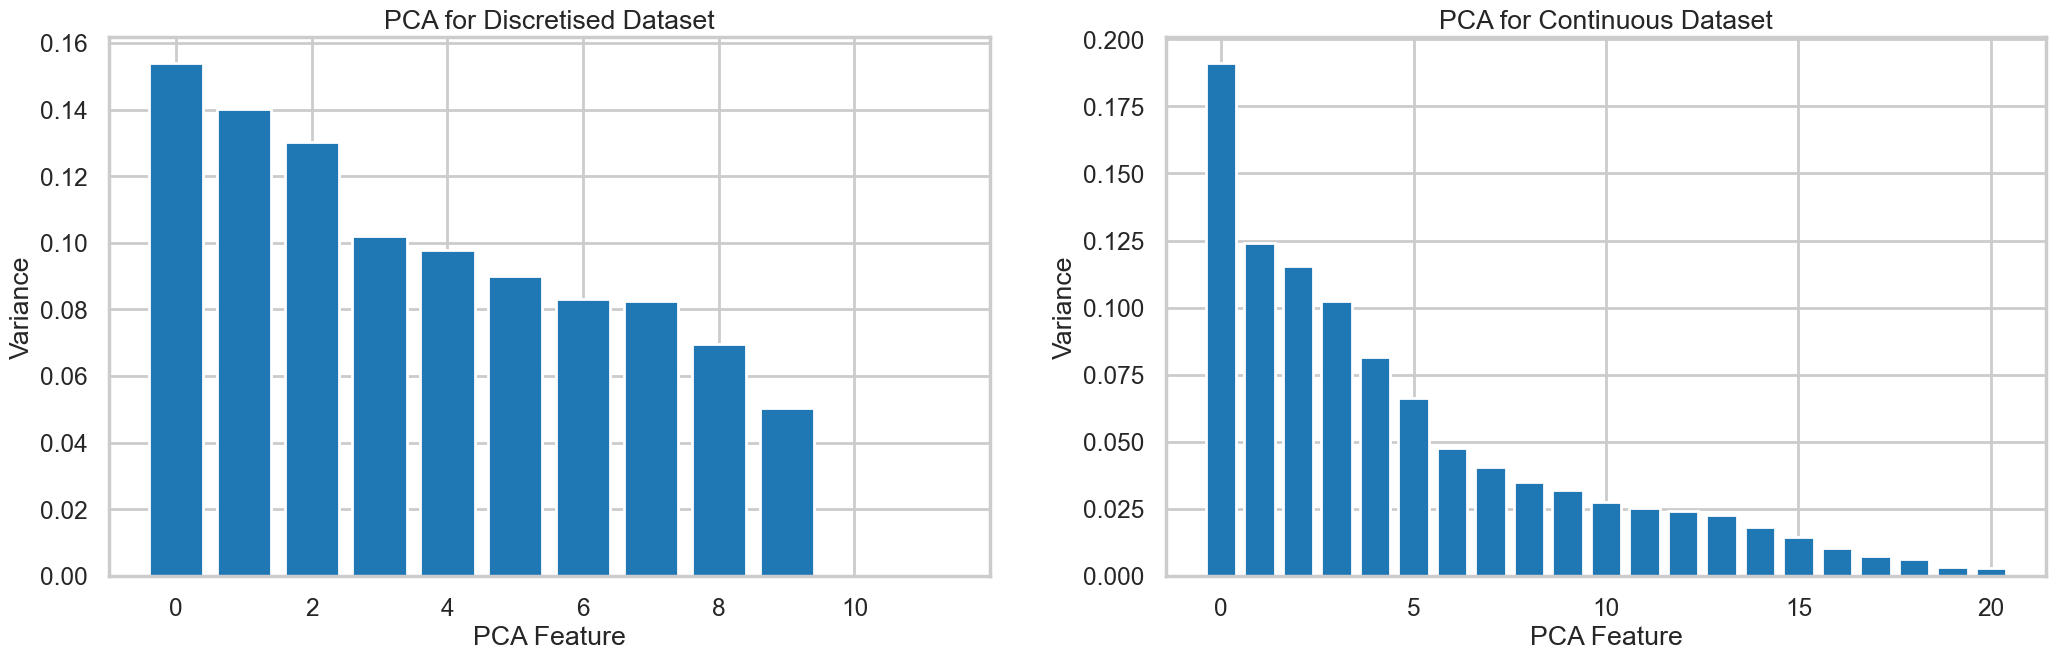

In [94]:
# Calculating PCA for both datasets, and graphing the Variance for each feature, per dataset
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('Class', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('Class', axis=1))
pca1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
fit1 = pca1.fit(X)

std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('Class', axis=1))
X = std_scale.transform(dataset_con_enc.drop('Class', axis=1))
pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
fit2 = pca2.fit(X)

# Graphing the variance per feature
sns.set_style('whitegrid')
plt.figure(figsize=(25,7)) 

plt.subplot(1, 2, 1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretised Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

plt.subplot(1, 2, 2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continuous Dataset')
plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_);

### Splitting Data into Training and Testing Datasets

In [95]:
train = dataset_con_enc.sample(frac=0.7)
test = dataset_con_enc.loc[~dataset_con_enc.index.isin(train.index)]
print(train.shape)
print(test.shape)

(5687, 23)
(2437, 23)


### Removing Missing Values 

In [96]:
train = train.dropna(axis=0)
test = test.dropna(axis=0)
print(f'Training data set shape :  {train.shape}')
print(f'Testing  data set shape :  {test.shape}')

Training data set shape :  (5687, 23)
Testing  data set shape :  (2437, 23)


In [97]:
X_train_w_label = train
X_train = train.drop(['Class'], axis=1)
y_train = train['Class'].astype('int64')
X_test = test.drop(['Class'], axis=1)
y_test = test['Class'].astype('int64')

In [98]:
X_train.shape
X_train.head()

,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,StalkShape,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
1556,2,2,4,0,5,1,1,0,3,1,...,0,7,7,0,2,1,0,3,0,1
4756,2,0,9,0,2,1,0,0,2,0,...,1,6,4,0,2,1,2,1,4,0
5140,3,2,0,1,5,1,0,0,8,0,...,2,7,7,0,2,2,4,5,4,1
3178,3,3,3,1,5,1,0,0,5,1,...,2,3,3,0,2,1,4,2,4,0
6137,3,2,4,0,8,1,0,1,0,1,...,1,7,7,0,2,1,0,7,4,0


In [99]:
y_train.head()

1556    1
4756    0
5140    0
3178    1
6137    0
Name: Class, dtype: int64

In [100]:
random.seed(10)

In [101]:
train_times = []
prediction_times = []

### Decision Tree 

In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

start_time = time.time()

# Initialize the Decision Tree Classifier with tunable parameters
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Train the classifier on the training data
dt_clf.fit(X_train, y_train)

# Predict on the test data
y_pred_dt = dt_clf.predict(X_test)

end_time = time.time()
train_time_df = end_time - start_time
train_times.append(train_time_df)

# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)


Decision Tree Accuracy: 1.0


### Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

start_time = time.time()

# Initialize the Random Forest Classifier with tunable parameters
rf_clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Train the classifier on the training data
rf_clf.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_clf.predict(X_test)

end_time = time.time()
train_time_rf = end_time - start_time
train_times.append(train_time_rf)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)


Random Forest Accuracy: 1.0


### Artificial Neural Network 


In [104]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import numpy as np


start_time = time.time()

# Define the architecture of the neural network
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Predict probabilities for each class
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_ann = (y_pred_prob > 0.5).astype(int)


end_time = time.time()
train_time_ann = end_time - start_time
train_times.append(train_time_ann)

# Calculate accuracy
accuracy_ann = accuracy_score(y_test, y_pred_ann)
print("ANN Accuracy:", accuracy_ann)


Epoch 1/10
160/160 [==============================] - 0s 1ms/step - loss: 0.3511 - accuracy: 0.8499 - val_loss: 0.2055 - val_accuracy: 0.9209
Epoch 2/10
160/160 [==============================] - 0s 595us/step - loss: 0.1496 - accuracy: 0.9490 - val_loss: 0.1073 - val_accuracy: 0.9613
Epoch 3/10
160/160 [==============================] - 0s 588us/step - loss: 0.0878 - accuracy: 0.9732 - val_loss: 0.0703 - val_accuracy: 0.9824
Epoch 4/10
160/160 [==============================] - 0s 590us/step - loss: 0.0564 - accuracy: 0.9828 - val_loss: 0.0609 - val_accuracy: 0.9842
Epoch 5/10
160/160 [==============================] - 0s 586us/step - loss: 0.0373 - accuracy: 0.9898 - val_loss: 0.0480 - val_accuracy: 0.9912
Epoch 6/10
160/160 [==============================] - 0s 636us/step - loss: 0.0225 - accuracy: 0.9947 - val_loss: 0.0208 - val_accuracy: 0.9965
Epoch 7/10
160/160 [==============================] - 0s 604us/step - loss: 0.0151 - accuracy: 0.9965 - val_loss: 0.0149 - val_accuracy: 0

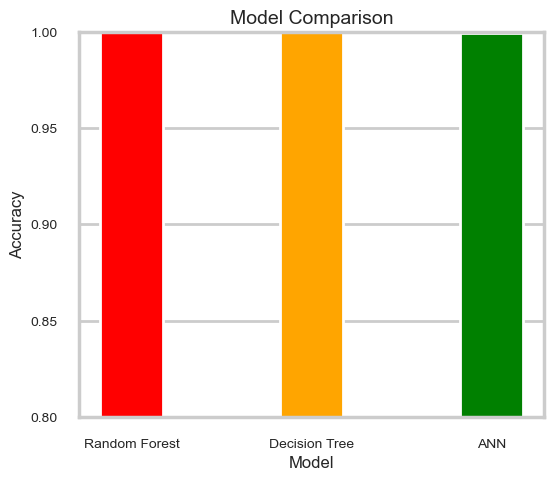

In [152]:
import matplotlib.pyplot as plt

models = ['Random Forest', 'Decision Tree', 'ANN']
accuracies = [accuracy_rf, accuracy_dt, accuracy_ann]

plt.figure(figsize=(6, 5))  # Adjust the figure size
plt.bar(models, accuracies, color=['red', 'orange', 'green'], width=0.35)
plt.xlabel('Model', fontsize=12)  # Adjust font size
plt.ylabel('Accuracy', fontsize=12)  # Adjust font size
plt.title('Model Comparison', fontsize=14)  # Adjust font size
plt.ylim(0.8, 1.0)
plt.xticks(fontsize=10)  # Adjust font size
plt.yticks(fontsize=10)  # Adjust font size
plt.show()

In [113]:
train_times


[0.01419973373413086, 0.24028325080871582, 1.4498107433319092]

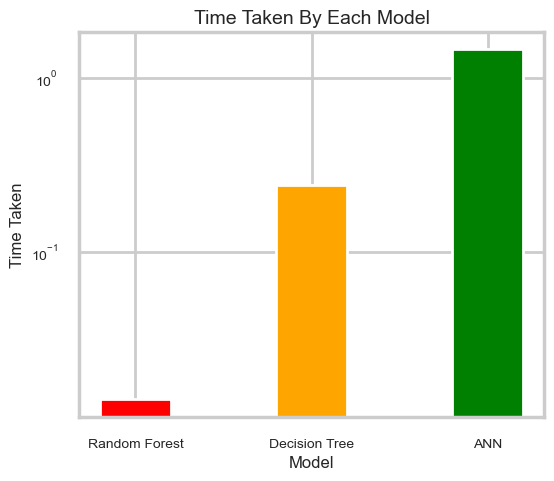

In [153]:
import matplotlib.pyplot as plt

models = ['Random Forest', 'Decision Tree', 'ANN']
sns.set_style('whitegrid')
plt.figure(figsize=(6, 5))  # Adjust the figure size
plt.bar(models, train_times, color=['red', 'orange', 'green'], width=0.4)
plt.xlabel('Model', fontsize=12)  # Adjust font size
plt.ylabel('Time Taken', fontsize=12) 
plt.yscale('log')
# Adjust font size
plt.title('Time Taken By Each Model', fontsize=14)  # Adjust font size
plt.xticks(fontsize=10)  # Adjust font size
plt.yticks(fontsize=10)  # Adjust font size
plt.show()     